# Importar Bibliotecas Necessárias
Importe as bibliotecas necessárias, como pandas, numpy, matplotlib, seaborn e scikit-learn.

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Carregar Dataset
Carregue o dataset contendo sintomas e diagnósticos correspondentes.

In [ ]:
# Carregar o dataset
caminho_dataset = r"src\analisys\data\dengue_sintomas_brasilia_limpo.csv"
dados = pd.read_csv(caminho_dataset, delimiter=';')

# Exibir estatísticas básicas do dataset
dados.describe()


,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CLASSI_FIN
count,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000,53185.000000
mean,0.870264,0.780389,0.761042,0.199192,0.221660,0.341318,0.288446,0.502153
std,0.336016,0.413987,0.426451,0.399396,0.415368,0.474156,0.453044,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110154 entries, 0 to 110153
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FEBRE       53185 non-null  float64
 1   MIALGIA     53185 non-null  float64
 2   CEFALEIA    53185 non-null  float64
 3   EXANTEMA    53185 non-null  float64
 4   VOMITO      53185 non-null  float64
 5   NAUSEA      53185 non-null  float64
 6   DOR_COSTAS  53185 non-null  float64
 7   CLASSI_FIN  53185 non-null  float64
dtypes: float64(8)
memory usage: 6.7 MB


# Análise Exploratória dos Dados
Realize análise exploratória dos dados (EDA) para entender a distribuição dos sintomas e suas relações com os diagnósticos.

<Figure size 2000x1500 with 0 Axes>

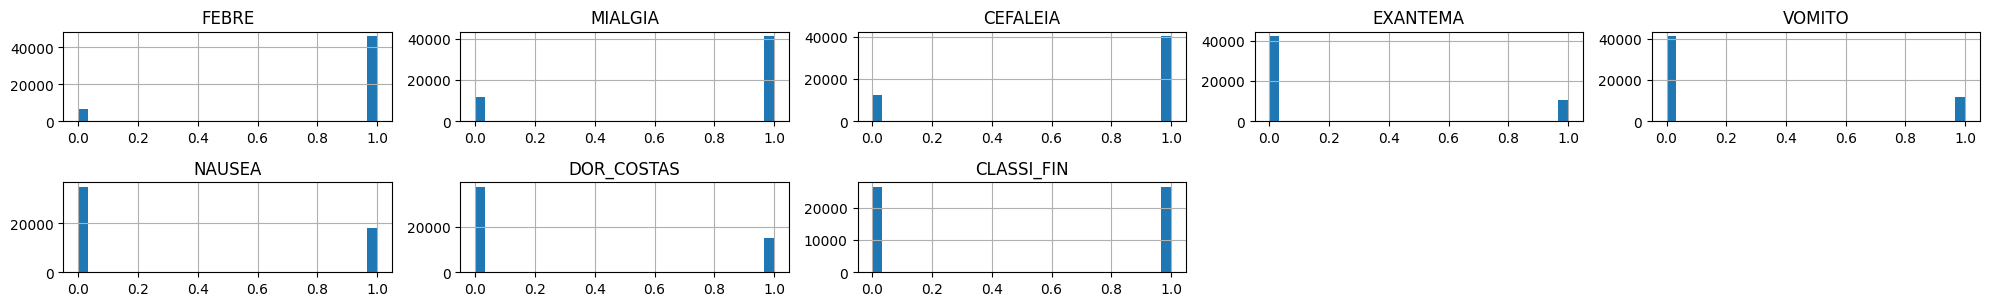

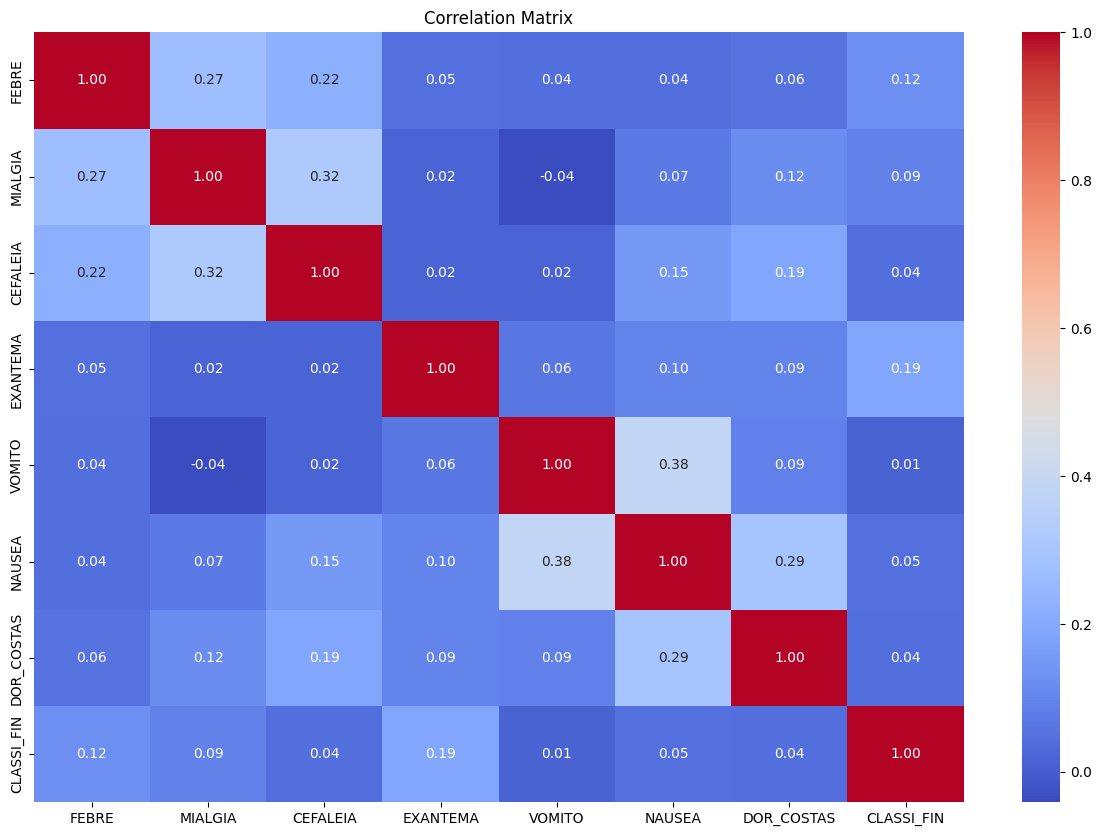

In [9]:
# Plotar a distribuição de cada sintoma
plt.figure(figsize=(20, 15))
dados.hist(bins=30, figsize=(20, 15), layout=(10, 5))
plt.tight_layout()
plt.show();

# Correlation matrix para entender a relação entre as variáveis
plt.figure(figsize=(15, 10))
correlation_matrix = dados.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show();

# Preparação dos Dados


In [10]:
# Lidar com valores faltantes
dados.ffill(inplace=True)  

# Separar as variáveis independentes da variável dependente
y = dados['CLASSI_FIN']
X = dados.drop('CLASSI_FIN', axis=1)

# Engenharia de Atributos
Crie novos atributos ou modifique os existentes para melhorar o desempenho do modelo.

In [11]:
# Criando interações entre as variáveis
X['FEBRE_MIALGIA'] = X['FEBRE'] * X['MIALGIA']
X['NAUSEA_VOMITO'] = X['NAUSEA'] * X['VOMITO']


# criando variáveis com o quadrado das variáveis originais
X['FEBRE_squared'] = X['FEBRE'] ** 2
X['FEBRE_squared'] = X['FEBRE'] ** 2
X['MIALGIA_squared'] = X['MIALGIA'] ** 2
X['NAUSEA_squared'] = X['NAUSEA'] ** 2
X['VOMITO_squared'] = X['VOMITO'] ** 2

X.head()

,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,FEBRE_MIALGIA,NAUSEA_VOMITO,FEBRE_squared,MIALGIA_squared,NAUSEA_squared,VOMITO_squared
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [12]:
# normalizando os dados
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# convertendo o array de volta para um DataFrame
X = pd.DataFrame(scaled_X, columns=X.columns)

# Lidando com desbalencemento de colunas com SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# checando a distribuição das classes após o resample
print(y_resampled.value_counts(normalize=True))

# dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

CLASSI_FIN
1.0    0.582013
0.0    0.417987
Name: proportion, dtype: float64


In [13]:
y_test.value_counts(), y_train.value_counts()

(CLASSI_FIN
 1.0    3169
 0.0    2333
 Name: count, dtype: int64,
 CLASSI_FIN
 1.0    12841
 0.0     9165
 Name: count, dtype: int64)

In [ ]:
X_test.to_csv(r"src\analisys\data\X_test.csv", index=False)
X_train.to_csv(r"src\analisys\data\X_train.csv", index=False)
y_test.to_csv(r"src\analisys\data\y_test.csv", index=False)  
y_train.to_csv(r"src\analisys\data\y_train.csv", index=False)    

# Treinamento e Avaliação do Modelo

In [15]:
# inicializando o modelo
model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, scale_pos_weight=1)

# definindo os hiperparâmetros
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, 2, 5, 10]
}

# perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# obtendo o melhor modelo
best_model = grid_search.best_estimator_

# fazer previsões
y_pred = best_model.predict(X_test)

# avaliar o modelo
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# realizar cross-validation
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=10, scoring='f1_weighted')

# mostrar os resultados
print("Cross-Validation Scores:", cv_scores)
print("Mean F1-Score:", cv_scores.mean())
print("Standard Deviation of F1-Score:", cv_scores.std())

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 5}
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2333
         1.0       1.00      1.00      1.00      3169

    accuracy                           1.00      5502
   macro avg       1.00      1.00      1.00      5502
weighted avg       1.00      1.00      1.00      5502

Confusion Matrix:
[[2333    0]
 [   0 3169]]
Cross-Validation Scores: [1.         1.         1.         0.99745436 0.99235611 1.
 1.         1.         1.         1.        ]
Mean F1-Score: 0.9989810473152836
Standard Deviation of F1-Score: 0.002335094529631647


### Interpretação
* Alto F1-Score Médio: O alto F1-score médio sugere que o modelo geralmente tem um bom desempenho.
* Variabilidade: A presença de duas pontuações mais baixas e o desvio padrão resultante indicam que o desempenho do modelo pode variar dependendo do subconjunto de dados em que é avaliado. Isso pode ocorrer devido ao desequilíbrio de classes ou características específicas dos dados nesses folds.


# Previsão

In [16]:
X.columns

Index(['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA',
       'DOR_COSTAS', 'FEBRE_MIALGIA', 'NAUSEA_VOMITO', 'FEBRE_squared',
       'MIALGIA_squared', 'NAUSEA_squared', 'VOMITO_squared'],
      dtype='object')

In [19]:
# dados para previsão sendo 1 = "sim" e 0 = "não"
febre = 1
dor_corpo = 0
dor_cabeca = 0
erupcao = 0
vomito = 0
nausea = 0
dor_costas = 0

# Supondo que 'dados' seja o DataFrame original usado para o treinamento
feature_names = X.columns.tolist()

# Novos dados para previsão (substituir por novos dados reais)
new_data = pd.DataFrame({
    'FEBRE': [febre], 
    'MIALGIA': [dor_corpo], 
    'CEFALEIA': [dor_cabeca], 
    'EXANTEMA': [erupcao], 
    'VOMITO': [vomito], 
    'NAUSEA': [nausea],
    'DOR_COSTAS': [dor_costas],
    'FEBRE_MIALGIA': [febre * dor_corpo],
    'NAUSEA_VOMITO' : [nausea * vomito],
    'FEBRE_squared': [febre**2],
    'VOMITO_squared': [vomito**2],
    'NAUSEA_squared': [nausea**2],
    'MIALGIA_squared': [dor_corpo**2],  
})

# Garantir que os novos dados tenham os mesmos nomes e ordem de atributos dos dados de treinamento
new_data = new_data[feature_names]

# Escalonar os novos dados usando o mesmo escalador
scaled_new_data = scaler.transform(new_data)

# Converter os dados de volta para um DataFrame
scaled_new_data = pd.DataFrame(scaled_new_data, columns=new_data.columns)

# fazer previsões
predictions = best_model.predict(scaled_new_data)

predictions = ['Negativo' if pred == 0 else 'Positivo' for pred in predictions]

# Interpretar as previsões
print("Previsão com dados informados:")
print(predictions)

Previsão com dados informados:
['Negativo']
